# Invaricance
So what’s invariance? In the context of neural networks, it means that the outcome (the prediction) is unchanged when the input is transformed. In the context of training an image classifier, image augmentation can be used to train a model to recognize an object regardless of the object’s size and location in the image, without the need for additional training data.

 Let’s consider a CNN that is an image classifier (this analogy can also be applied to object detection). We want the object being classified to be correctly recognized regardless of its location in the image. If we transform the input so that the object is shifted to a new location in the image, we want the outcome (the prediction) to remain unchanged.

 For CNNs and imaging in general, the primary types of invariance we want the model to support are translational and scale invariance. Prior to 2019, translational and scale invariance were handled by image augmentation preprocessing upstream from the model training, using preprocessing of the image data on a CPU while the data was fed during training on a GPU. We will discuss these traditional techniques in this section.

One approach to training for translational/scale invariance is simply to have enough images per class (per object), so that the object is in different locations in the image, different rotations, different scales, and different view angles. Well, this may not be practical to collect.


 It turns out there is a straightforward method of autogenerating translational/ scale invariant images using image augmentation preprocessing, which is performed efficiently using matrix operations. Matrix-based transforms can be done by a variety of Python packages, such as the TF.Keras ImageDataGenerator class, TensorFlow tf.image module, or OpenCV.

<img src="img_14.png" />


## Translational invariance
This subsection covers how to manually augment images in a training dataset such that the model learns to recognize the object in the image regardless of its location in the image. For example, we want the model to recognize a horse regardless of which direction the horse faces in the image, or an apple regardless of where in the background the apple is located.

Translational invariance in the context of image input includes the following:
1. Vertical/horizontal location (object can be anywhere in the picture)
2. Rotation (object can be at any rotation)

A vertical/horizontal transformation is typically performed either as a matrix roll operation or a crop.

An orientation (for example, mirror) is typically performed as a matrix flip.

A rotation is typically handled as a matrix transpose.


#### Flip
A matrix flip transforms an image by flipping it either on the vertical or horizontal axis. Since the image data is represented as a stack of 2D matrices (one per channel), a flip can be done efficiently as a matrix transpose function without changes (such as interpolation) of the pixel data. Figure 4.12 compares an original and flipped versions of an image

<img src="img_15.png" />

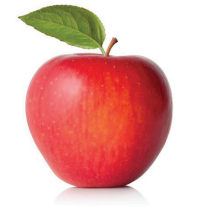

In [3]:
from PIL import Image, ImageOps
img = Image.open('aple.png')
img

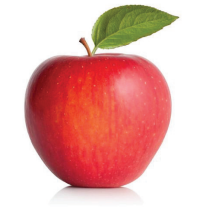

In [4]:
flip = img.transpose(Image.FLIP_LEFT_RIGHT)
flip

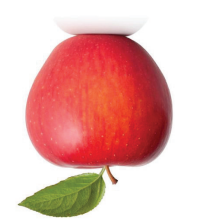

In [5]:
flip = img.transpose(Image.FLIP_TOP_BOTTOM)
flip

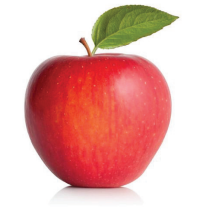

In [6]:
flip = ImageOps.mirror(img)
flip

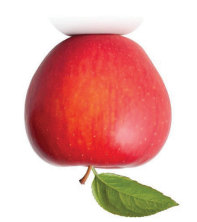

In [7]:
ImageOps.flip(flip)

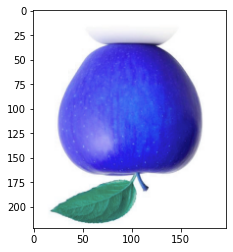

In [8]:
import cv2
import matplotlib.pyplot as plt
image = cv2.imread('aple.png')
flip = cv2.flip(image, 0)
plt.imshow(flip)

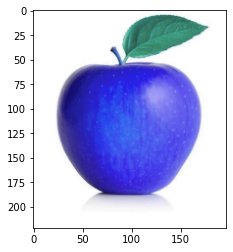

In [9]:
import cv2
import matplotlib.pyplot as plt
flip = cv2.flip(image, 1)
plt.imshow(flip)

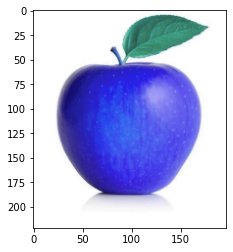

In [10]:
import numpy as np

flip = np.flip(image, 1)
plt.imshow(flip)

#### ROTATE 90/180/270
In addition to flips, a matrix transpose operation can be used to rotate an image 90 degrees (left), 180 degrees, and 270 degrees (right). Like a flip, the operation is efficient, does not require interpolation of pixels, and does not have a side effect of clipping. Figure 4.13 compares the original and 90-degree rotation versions.

<img src="img_16.png" />

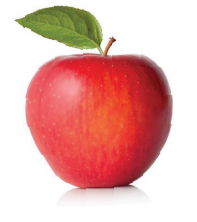

In [11]:
rotate = img.rotate(Image.ROTATE_90)
rotate

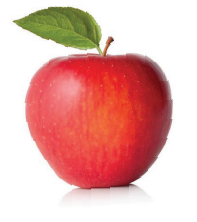

In [12]:
rotate = img.rotate(Image.ROTATE_180)
rotate

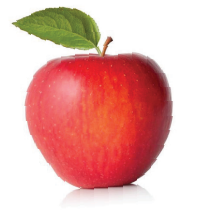

In [13]:
rotate = img.rotate(Image.ROTATE_270)
rotate

OpenCV does not have a transpose method for 90 or 270 degrees; you can do a 180 by
using the flip method with a value of –1. (All other rotations using OpenCV are
demonstrated in the following subsection, using the imutils module.

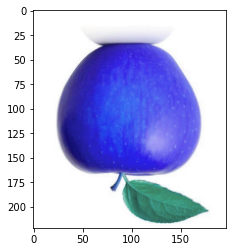

In [14]:
rotate_cv = cv2.flip(image, -1)
plt.imshow(rotate_cv)

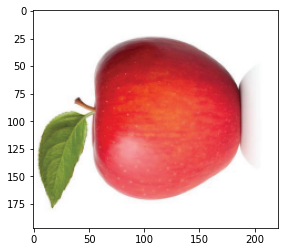

In [15]:
rotate = np.rot90(img, 1)
plt.imshow(rotate)

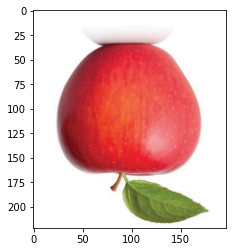

In [16]:
rotate = np.rot90(img, 2)
plt.imshow(rotate)

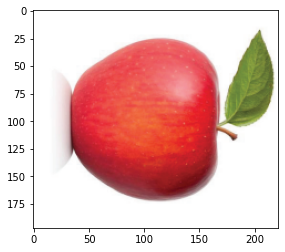

In [17]:
rotate = np.rot90(img, 3)
plt.imshow(rotate)

#### ROTATION
A rotation transforms an image by rotating it within –180 and 180 degrees. Generally, the degree of rotation is randomly selected. You may also want to limit the range of rotation to match the environment the model will be deployed in. Here are some common practices:

1. If the images will be dead-on, use a range of –15 to 15 degrees.
2. If the images may be on an incline, use a range of –30 to 30 degrees.
3. For small objects, like packages or money, use the full range of –180 to 180 degrees.


Another issue with rotation is that if you rotate an image within the same-size boundaries, other than 90, 180, or 270, a
portion of the image’s edge will end up outside the boundary

In [18]:
import imutils

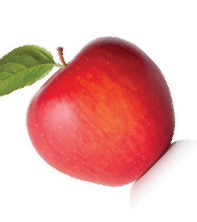

In [20]:
rotate = img.rotate(45)
rotate

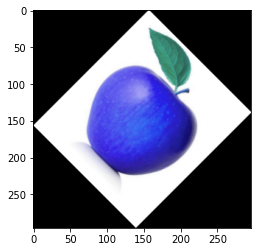

In [24]:

shape = (image.shape[0], image.shape[1])
rotate = imutils.rotate_bound(image, 45)
plt.imshow(rotate)

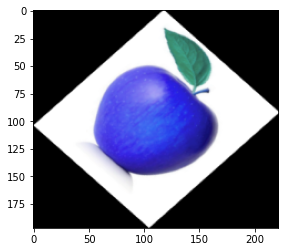

In [25]:
rotate = cv2.resize(rotate, shape, interpolation=cv2.INTER_AREA)
plt.imshow(rotate)

#### SHIFT
A shift will shift the pixel data in the image +/– in the vertical (height) or horizontal (width) axis. This will change the location in the image of the object being classified. Figure 4.15 shows the apple image shifted down 10% and up 10%.

<img src="img_17.png"/>


The following code demonstrates shifting the image +/– 10% vertically and horizontally by using the NumPy np.roll() method:

In [29]:
image = cv2.imread("aple.png")
height = image.shape[0]
width = image.shape[1]


**ship the image down 10%**
np.roll(axis = 0) -> up + down
np.roll(image, +-height, axis = 0) down +  up

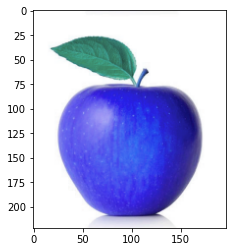

In [35]:
roll = np.roll(image, height // 10, axis = 0)
plt.imshow(roll)

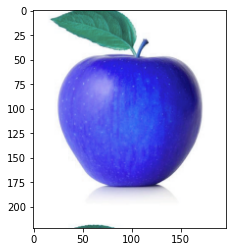

In [32]:
roll = np.roll(image, -height // 30, axis = 0)
plt.imshow(roll)

**shift the image left, right**
np.roll(image, +-width, axis = 1) right, left

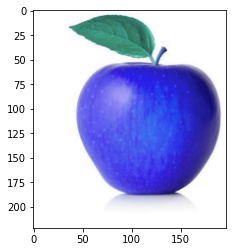

In [36]:
roll = np.roll(image, width //10 , axis= 1)
plt.imshow(roll)

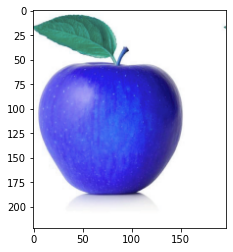

In [37]:
roll = np.roll(image, - width //10 , axis= 1)
plt.imshow(roll)

A shift is efficient in that it is implemented as a roll operation of the matrix; the rows (height) or columns (width) are
shifted. As such, the pixels that are shifted off the end are
added to the beginning.
 If the shift is too large, the image can become fractured
into two pieces, with each piece opposing the other. Figure
4.16 shows the apple shifted by 50% vertically, leaving it
fractured.

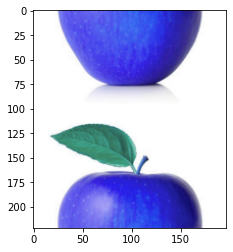

In [41]:
roll = np.roll(image, - height //2 , axis= 0)
plt.imshow(roll)

To avoid fracture, limiting the shift of the image to no more than 20% is a general practice. Alternatively, we could crop the image and fill the cut-off space with a black pad, as demonstrated here using OpenCV:

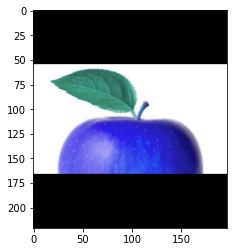

In [43]:
image2 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image2 = image[0: height//2, :, :]  # Drop the bottom of the image 50%
image2 = cv2.copyMakeBorder(image2, (height//4), (height//4), 0, 0,   cv2.BORDER_CONSTANT, 0) # Makes black border to refit the image back to its original size
plt.imshow(image2)

## Scale invariance
This subsection covers how to manually augment images in a training dataset such that the model learns to recognize the object in the image regardless of the object’s size. For example, we want the model to recognize an apple regardless whether it takes up most of the image or is a small fraction of the image overlaid on a background.

 Scale invariance in the context of an image input includes the following:
 1. Zoom (object can be any size in the image)
 2. Affine (object can be viewed from any perspective)


### ZOOM

Zoom transforms an image by zooming in from the center of the image, which is done with a resize-and-crop operation. You find the center of the image, calculate the crop bounding box around the center, and then crop the image.

When enlarging an image by using Image.resize() the Image.BICUBIC interpolation generally provides the best results. This code demonstrates how to zoom into an image by using Python’s PIL imaging library:

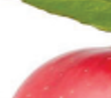

In [49]:
zoom = 2
img_zoom = img.resize((int(height*zoom), int(width*zoom)), Image.BICUBIC)
center = (height//2, width//2)
crop = (center[0]//zoom, center[1]//zoom)
box = (crop[0], crop[1], (center[0] + crop[0]), (center[1] + crop[1]))
img_zoom = img_zoom.crop(box)
img_zoom

##  TF.Keras ImageDataGenerator
The TF.Keras image-preprocessing module supports a wide variety of image augmentation with the class ImageDataGenerator. This class creates a generator for generating batches of augmented images. The class initializer takes as input zero or more parameters for specifying the type of augmentation. Here are a few of the parameters, which we will cover in this section:
 horizontal_flip=True|False
 vertical_flip=True|False
 rotation_range=degrees
 zoom_range=(lower, upper)
 width_shift_range=percent
 height_shift_range=percent
 brightness_range=(lower, upper)

In the following code example, we do the following:
1. Read in a single image of an apple.
2. Create a batch of one image (the apple).
3. Instantiate an ImageDataGenerator object.
4. Initialize the ImageDataGenerator with our augmentation options (in this case, horizontal and vertical flips).
5. Use the flow() method of ImageDataGenerator to create a batch generator.
6. Iterate through the generator six times, each time returning a batch of one image in x.
    – The generator will randomly select an augmentation (including no augmentation) per iteration.
    – After transformation (augmentation), the pixel value type will be 32-bit float.
    – Change the data type of the pixels back to 8-bit integer, for displaying using
    Matplotlib.

In [51]:
from keras.preprocessing.image import ImageDataGenerator
# 1 REad an image
image = cv2.imread('aple.png')
# 2 create a batch of an image
batch = np.asarray([image])

In [53]:
image.shape, batch.shape

((222, 197, 3), (1, 222, 197, 3))

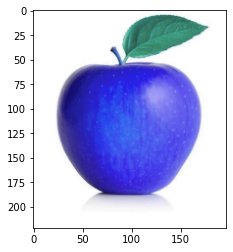

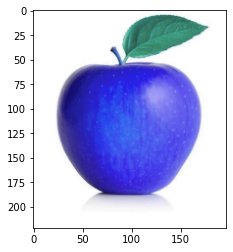

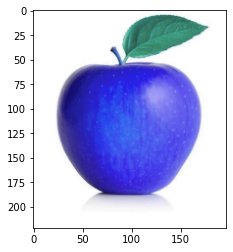

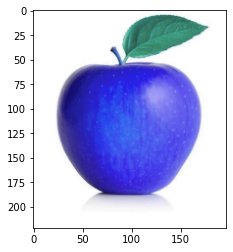

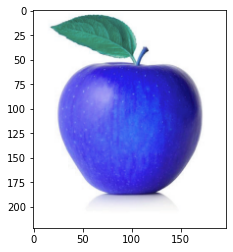

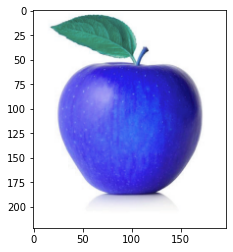

In [55]:
step=0
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
for x in datagen.flow(batch, batch_size=1):
 step += 1
 if step > 6: break
 plt.figure()
 plt.imshow(x[0].astype(np.uint8))

### ROTATION
In the following code, we use the rotation_range parameter to set random rotations
between –60 and 60 degrees. Note that rotate operation does not perform a bounds
check and resize (like imutils.rotate_bound()), so part of the image may end up
being clipped:
datagen = ImageDataGenerator(rotation_range=60

### ZOOM
In this code, we use the zoom_range parameter to set random values from 0.5 (zoom
out) to 2 (zoom in). The value can be specified either as a tuple or list of two
elements:
datagen = ImageDataGenerator(zoom_range=(0.5, 2))

### SHIFT
In this code, we use width_shift_range and height_shift_range to set random values from 0 to 20% to shift horizontally or vertically:
datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2

### BRIGHTNESS
In the following code, we use the brightness_range parameter to set random values
from 0.5 (darker) to 2 (brighter). The value can be specified either as a tuple or list of
two elements:
datagen = ImageDataGenerator(brightness_range=(0.5, 2))
As a final note, transformations like brightness that add a fixed amount to the pixel
value are done after normalization or standardization. If done before, normalization
and standardization would squash the values into the same original range, undoing
the transformation